### Counting Cards

| Cards thrown out | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | J | Q | K | A | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Card Value | -1 |  -1 |  -1 |  -1 |  -1 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1 |

Calculate the effectiveness of counting cards to the winnings of playing Blackjack. Counting is a strategy in Blackjack where it determines the bet value the player have to make in order to maximise winnings. To calculate the $count$, it follows the table above. However, to calculate the $true\_count$ is $\frac{count}{n_{decks}}$. Hence, we have the following amount for the bets:

$$bet = (true\_count - 1) * bet\_unit$$

After knowing what to bet, use the following strategies to play around the cards on doing the actions (`HIT`, `STAND` or `DOUBLE`).

<center>
    <img src="images/HardTotals_Strategy.png"/> <img src="images/SoftTotals_Strategy.png"/>
</center>

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
CARDS = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
VALUE = [[1, 11], 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
CARDS_COUNT = [1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1]
N_DECKS = 6
N_CARD_EACH_DECK = 4
START_NUM_CARDS = [N_DECKS * N_CARD_EACH_DECK] * len(CARDS)
BET_UNIT = 5
MIN_BETS = 0
DECK_LIMIT = 4
CARD_LIMIT = DECK_LIMIT * len(CARDS) * N_CARD_EACH_DECK
PLOT_COLOR = '#4169e1'

In [4]:
class blackjack():
    def __init__(self, num_cards, count, bet):
        self.cards, self.bust = {'p': [], 'd': []}, {'p': False, 'd': False}
        self.value = {'p': 0, 'd': 0}
        self.num_cards, self.count = num_cards, count
        self.pcd = 0
        self.bet = bet
        self.winner = ''
    
    def hit(self, target = 'p'):
        assert target in ['p', 'd']
        
        prob = [num/sum(self.num_cards) for num in self.num_cards]
        index = np.random.choice(len(CARDS), replace = True, p = prob)
        value = VALUE[index]
        self.num_cards[index] = self.num_cards[index] - 1
        self.count = self.count + CARDS_COUNT[index]
        if target == 'p': self.pcd += 1
        
        if len(self.cards[target]) == 0:
            if type(value) == list: self.cards[target] = value.copy()
            else: self.cards[target].append(value)
        
        else:
            dealer_special = 1 if target == 'd' else 0
            if type(value) == list:
                self.cards[target] = [val1 + val2 for val1 in self.cards[target] for val2 in value if val1 + val2 <= 21 + dealer_special]
                if len(self.cards[target]) == 0: self.bust[target] = True
                
            else:
                self.cards[target] = [val1 + value for val1 in self.cards[target] if val1 + value <= 21 + dealer_special]
                if len(self.cards[target]) == 0: self.bust[target] = True
        
        self.value[target] = 0 if self.bust[target] else np.max(self.cards[target])
    
    def run_dealer_cards(self):
        while self.value['d'] <= 16: 
            self.hit('d')
            if self.bust['d']: break
    
    def start(self):
        new_game.hit('p')
        new_game.hit('d')
        new_game.hit('p')
    
    def double(self):
        self.bet = self.bet * 2
        self.hit('p')
        
    def find_winners(self):
        if self.value['p'] == 21 and len(self.cards['p']) == 2:
            self.bet = self.bet * 1.5
            self.winner = 'p'
        elif self.bust['p'] or self.value['p'] < self.value['d']: 
            self.winner = 'd'
            self.bet = -self.bet
        elif self.bust['d'] or self.value['p'] > self.value['d'] or self.pcd >= 5: self.winner = 'p'
        elif (self.value['d'] == 22 or self.value['p'] == self.value['d']) and not self.bust['p']: 
            self.winner = 'none'
            self.bet = 0

In [5]:
## Playing alone with dealer
n_sim = 25000
sim_r = []
sim_p = []
sim_d = []

num_cards = START_NUM_CARDS.copy()
count = 0
running_count = []

for sim in tqdm(range(n_sim)):
    if sum(num_cards) < CARD_LIMIT:
        num_cards = START_NUM_CARDS.copy()
    
    true_count = count / N_DECKS
    bet_value  = (true_count - 1) * BET_UNIT
    
    if bet_value < MIN_BETS:
        new_game = blackjack(num_cards, count, 0)
        new_game.run_dealer_cards()
        num_cards, count = new_game.num_cards, new_game.count
        sim_r.append(0)
        sim_p.append(-1)
        sim_d.append(new_game.value['d'])
        
    else:
        new_game = blackjack(num_cards, count, bet_value)
        new_game.start()
        
        while new_game.value['p'] < 21:
            
            if new_game.bust['p']: break
            
            if len(new_game.cards['p']) == 2:
                
                if new_game.value['p'] == 20: break
                
                elif new_game.value['p'] == 19:
                    if new_game.value['d'] == 6: new_game.double()
                    else: break
                
                elif new_game.value['p'] == 18:
                    if new_game.value['d'] <= 6:  new_game.double()
                    else: break
                
                elif new_game.value['p'] == 17:
                    if new_game.value['d'] <= 6 and new_game.value['d'] >= 3: new_game.double()
                    else: break
            
                elif new_game.value['p'] == 16 or new_game.value['p'] == 15:
                    if new_game.value['d'] <= 6 and new_game.value['d'] >= 4: new_game.double()
                    else: break
                    
                elif new_game.value['p'] == 14 or new_game.value['p'] == 13:
                    if new_game.value['d'] <= 6 and new_game.value['d'] >= 5: new_game.double()
                    else: break
                    
                elif new_game.value['p'] == 12:
                    if new_game.value['d'] <= 6 and new_game.value['d'] >= 4: break
                    else: new_game.hit()
    
            else:
                
                if new_game.value['p'] >= 17: break
                if new_game.value['p'] == 11: new_game.double()
                
                if new_game.value['p'] <= 16 and new_game.value['p'] >= 13:
                    if new_game.value['d'] <= 6: break
                    else: new_game.hit()
                
                if new_game.value['p'] == 12:
                    if new_game.value['d'] <= 6 and new_game.value['d'] >= 4: break
                    else: new_game.hit()
                
                if new_game.value['p'] == 10:
                    if new_game.value['d'] <= 9: new_game.double()
                    else: new_game.hit()
                
                if new_game.value['p'] == 9:
                    if new_game.value['d'] <= 6 and new_game.value['d'] >= 3: new_game.double()
                    else: new_game.hit()
                
                else: new_game.hit()
        
        new_game.run_dealer_cards()
        new_game.find_winners()
        num_cards, count = new_game.num_cards, new_game.count
        sim_r.append(new_game.bet)
        sim_p.append(new_game.value['p'])
        sim_d.append(new_game.value['d'])
    
    running_count.append(count)

100%|█████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 13002.21it/s]


In [6]:
## What is the probability of dealer to bust
p_bust_d = sum([val == 0 for pval, val in zip(sim_p, sim_d) if pval >= 0])/len([p for p in sim_p if p >= 0])

## What is the probability of dealer to standoffs
p_stof = sum([val == 0 for pval, val in zip(sim_p, sim_r) if pval >= 0])/len([p for p in sim_p if p >= 0])

## Probability of dealer having high cards (18 19 20)
p_high_d = (sum([val < 21 for pval, val in zip(sim_p, sim_d) if pval >= 0]) - sum([val < 18 for pval, val in zip(sim_p, sim_d) if pval >= 0]))/len([p for p in sim_p if p >= 0])

## Probability of dealer having blackjack
p_bljk_d = sum([val == 21 for pval, val in zip(sim_p, sim_d) if pval >= 0])/len([p for p in sim_p if p >= 0])

## Probability of dealer wins
p_win_d  = sum([val < 0 for pval, val in zip(sim_p, sim_r) if pval >= 0])/len([p for p in sim_p if p >= 0])

print(f"Bust: {p_bust_d},  Stand-off: {p_stof}, High: {p_high_d}, Blackjack: {p_bljk_d}, Probability of Dealer to Win: {p_win_d}")

Bust: 0.2048780487804878,  Stand-off: 0.17317073170731706, High: 0.45365853658536587, Blackjack: 0.13170731707317074, Probability of Dealer to Win: 0.5829268292682926


In [7]:
## What is the probability of player to bust
p_bust_p = sum([val == 0 for pval, val in zip(sim_p, sim_p) if pval >= 0])/len([p for p in sim_p if p >= 0])

## Probability of player having high cards (18 19 20)
p_high_p = (sum([val < 21 for pval, val in zip(sim_p, sim_p) if pval >= 0]) - sum([val < 18 for pval, val in zip(sim_p, sim_d) if pval >= 0]))/len([p for p in sim_p if p >= 0])

## Probability of player having blackjack
p_bljk_p = sum([val == 21 for pval, val in zip(sim_p, sim_p) if pval >= 0])/len([p for p in sim_p if p >= 0])

## Probability of player wins
p_win_p  = sum([val > 0 for pval, val in zip(sim_p, sim_r) if pval >= 0])/len([p for p in sim_p if p >= 0])

print(f"Bust: {p_bust_p}, High: {p_high_p}, Blackjack: {p_bljk_p}, Probability of Player to Win: {p_win_p}")

Bust: 0.3439024390243902, High: 0.5926829268292683, Blackjack: 0.05365853658536585, Probability of Player to Win: 0.24390243902439024


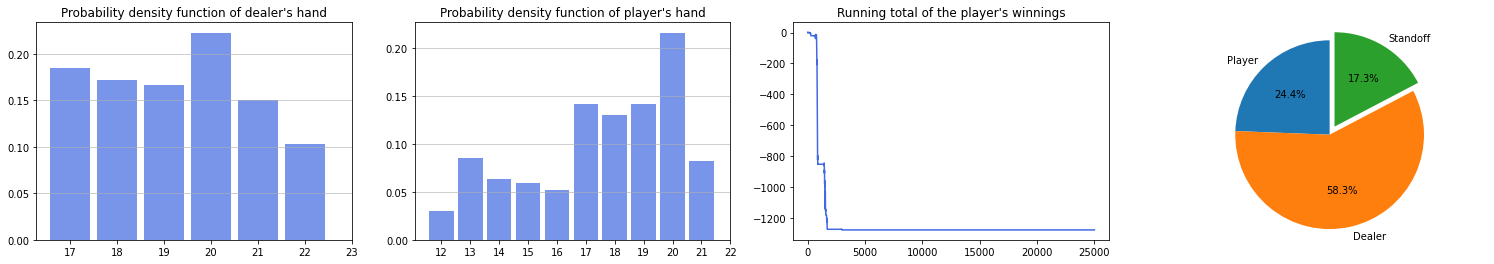

In [8]:
labels = 'Player', 'Dealer', 'Standoff'
sizes = [p_win_p, p_win_d, p_stof]
explode = (0, 0, 0.1)
n_possible_player_values = len(set([p for p in sim_p if p > 0])) + 1
n_possible_dealer_values = len(set([p for p in sim_d if p > 0])) + 1

fig, ax = plt.subplots(1, 4, figsize = (26, 4))
ax[0].hist(x = [p for p in sim_d if p > 0], bins = np.arange(n_possible_dealer_values) + 17 - 0.5, color = PLOT_COLOR,
                            alpha=0.7, rwidth=0.85, density = True)
ax[0].grid(axis='y', alpha=0.75)
ax[0].set_xticks(np.arange(n_possible_dealer_values) + 17)
ax[0].set_title("Probability density function of dealer's hand")

ax[1].hist(x = [p for p in sim_p if p > 0], bins = np.arange(n_possible_player_values) + 12 - 0.5, color = PLOT_COLOR,
                            alpha=0.7, rwidth=0.85, density = True)
ax[1].grid(axis='y', alpha=0.75)
ax[1].set_xticks(np.arange(n_possible_player_values) + 12)
ax[1].set_title("Probability density function of player's hand")

ax[2].plot(np.cumsum(sim_r), color = PLOT_COLOR)
ax[2].set_title("Running total of the player's winnings")

ax[3].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax[3].axis('equal')
plt.show()